In [2]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from math import e
from math import pi
from astropy.table import Column
from math import sqrt
import numpy as np
import emcee
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import math
import corner
from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb
import powerlaw
import random

AP_data_table: ['APID', 'RegID', 'logAge-Best', 'logAge-P16', 'logAge-P84', 'logMass-Best', 'logMass-P16', 'logMass-P84']


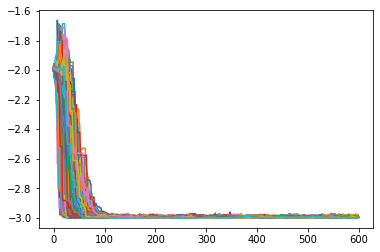

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


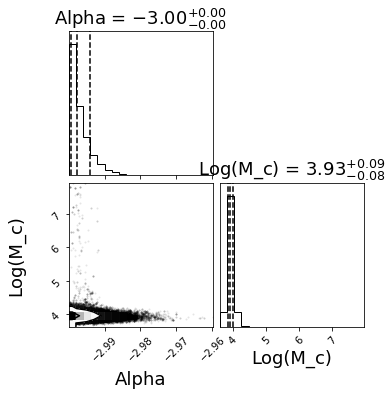

In [3]:
AP_data_table=Table.read("APData_csv.csv")
print("AP_data_table:", AP_data_table.colnames)

M=np.array(AP_data_table['logMass-Best'])
Tau= np.array(AP_data_table['logAge-Best'])

def M_lim(Tau):
    for age in Tau:
        if 7.0 < age < 8.0 :
            return 740
        if 8.0 < age < np.log10(300000000) : 
            return 1080

def lnobs_like(M):
    a_lim=5.0
    for mass in M:
        if mass > 3:
            return -np.log(1+ exp(-a_lim*(M-3)))
        else:
            return -np.inf
        
def lnZ(theta, M):
    alpha, M_c = theta
    a_lim=5.0
    lin_M_c= 10**M_c
    def f(M):
        if np.log10(M) > 3:
            return (M**alpha)*exp(-M/lin_M_c)*((1+ exp(-a_lim*(np.log10(M)-3)))**(-1))
        else:
            return 0
    ans, err = quad(f, 1080, np.inf)
    return np.log(ans)
    
def lnlike(theta, M):
    alpha, M_c = theta
    lin_M= 10**M
    lin_M_c= 10**M_c
    return np.sum((-lin_M/lin_M_c) + alpha*np.log(lin_M) + lnobs_like(M) - lnZ(theta, lin_M))
    
def lnprior(theta):
    alpha, M_c = theta
    if -3 <= alpha <= -1 and 3 <= M_c <= 8:
        return 0.0
    return -np.inf

def lnprob(theta, M):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, M)

starting_point=np.array([-1.99, 3.93])

ndim, nwalkers = 2, 500
nsteps= 600
burnin=100
pos = starting_point + 1e-2*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=([M]))
sampler.run_mcmc(pos, nsteps)

#plot chain
plt.plot(np.transpose(sampler.chain[:,:,0]))
plt.show()
sampler.chain
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["Alpha", "Log(M_c)"], label_kwargs={"fontsize": 18},
                                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})

fig.show()